<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/TwitterImport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter/X Network Analysis (Notebook)

In this notebook, we will analyze a real-world social network dataset inspired by Twitter/X.
Our goal is to represent the data as a graph and use basic tools from network science to
inspect and visualize the structure of the network.

By the end of this notebook, you should be able to:
- load network data from a file,
- build a graph in NetworkX,
- visualize the network,
- compute a few basic graph statistics.

### Setup: Python packages

Before working with the data, we need a few standard Python libraries:
- **NumPy** for numerical utilities,
- **Matplotlib** (specifically `matplotlib.pyplot`) for plotting,
- **NetworkX** for building and analyzing graphs.

The cell below installs missing packages (safe to run even if they are already installed)
and then imports the libraries we will use.

In [1]:
# Install required packages (safe to run multiple times)
%pip install -q matplotlib networkx numpy

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Note: you may need to restart the kernel to use updated packages.


## Data source: Twitter/X ego networks (SNAP)

This notebook is inspired by the Twitter/X ego-network datasets curated by the
**Stanford Network Analysis Project (SNAP)**:
https://snap.stanford.edu/data/ego-Twitter.html

For reproducibility and ease of use, we will work with a smaller edge-list file:
`TwitterLinksSmall.txt`, hosted as a GitHub Release asset.

Each line of the file represents an edge between two user IDs (one edge per line).

In [2]:
from pathlib import Path
import urllib.request

DATA_URL = "https://github.com/vmpreciado/DS4CN/releases/download/v1.0/TwitterLinksSmall.txt"
DATA_DIR = Path("data")
DATA_PATH = DATA_DIR / "TwitterLinksSmall.txt"

DATA_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_PATH.exists():
    print(f"Downloading dataset from:\n  {DATA_URL}")
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)
    print(f"Saved to:\n  {DATA_PATH.resolve()}")
else:
    print(f"Dataset already present at:\n  {DATA_PATH.resolve()}")

# Path to the edge list file used in the rest of the notebook
file_path = str(DATA_PATH)
print("Using file path:", file_path)

  https://github.com/vmpreciado/DS4CN/releases/download/v1.0/TwitterLinksSmall.txt
Saved to:
  /Users/victormpreciado/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/data/TwitterLinksSmall.txt
Using file path: data/TwitterLinksSmall.txt


### Inspect the dataset

Let’s start by inspecting the dataset format.

In the next cell, we open the downloaded text file (stored locally under the path `file_path`)
and print the first 20 *non-empty* lines. This quick “peek” helps us confirm how the data is
structured before we build a graph from it.

In [3]:
# Preview the first 20 non-empty lines of the edge list file
n_preview = 20
shown = 0

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line == "":
            continue  # skip empty lines
        print(line)
        shown += 1
        if shown >= n_preview:
            break

print("... the list of edges goes on ...")

214328887 34428380
17116707 28465635
380580781 18996905
221036078 153460275
107830991 17868918
151338729 222261763
19705747 34428380
222261763 88323281
19933035 149538028
158419434 17434613
149538028 153226312
364971269 153226312
100581193 279787626
113058991 69592091
151338729 187773078
406628822 262802533
460282402 88323281
280935165 437804658
222261763 27633075
285312927 151338729
... the list of edges goes on ...


In this dataset, each line represents a **directed edge** in the Twitter/X network,
encoding a “who-follows-who” relationship.

A line of the form:

`u v`

is interpreted as the directed edge \(u \rightarrow v\), meaning **user `u` follows user `v`**.

This file is a small, course-friendly subset of a larger Twitter/X ego-network dataset
originally curated by Stanford’s SNAP project. In the next steps, we will convert this
edge list into a directed graph in NetworkX.

## Creating a directed graph from the data

We now convert the edge list stored in the text file into a **directed graph**
represented as a `DiGraph` object in NetworkX.

In the code below:
- we first create an empty directed graph `D`,
- then read the file line by line,
- interpret each line as a directed edge,
- and add that edge to the graph.

Once this step is complete, the object `D` contains the full Twitter/X subnetwork
in a form that allows us to apply graph algorithms and compute network statistics.

In [5]:
# Create an empty directed graph
D = nx.DiGraph()

# Read the edge list file line by line
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        line = line.strip()
        if not line:
            continue  # skip empty lines

        # Each line contains two integers: source and target
        source, target = map(int, line.split())

        # Add the directed edge source -> target
        D.add_edge(source, target)

# At this point, D is a directed graph containing all nodes and edges from the dataset

With our directed graph `D` constructed, we can now explore its scale.

In the next step, we will examine:
- the total number of nodes (users),
- the total number of edges (follower relationships),

to gain a first quantitative sense of the size of this Twitter/X subnetwork.

In [ ]:
num_nodes = len(D.nodes())
num_edges = len(D.edges())
print("Number of Nodes:", num_nodes)
print("Number of Nodes:", num_edges)

Number of Nodes: 81306
Number of Nodes: 1768149


### Sparsity visualization

A directed graph can be represented by its **adjacency matrix** $A$, where
$A_{ij} = 1$ if there is a directed edge $i \rightarrow j$, and
$A_{ij} = 0$ otherwise.

For directed graphs, the adjacency matrix is generally **not symmetric**,
since $i \rightarrow j$ does not imply $j \rightarrow i$.

Because Twitter/X networks are very large but typically sparse, it is often
more informative to visualize the **sparsity pattern** of $A$
(i.e., the locations of nonzero entries) rather than printing the full matrix.

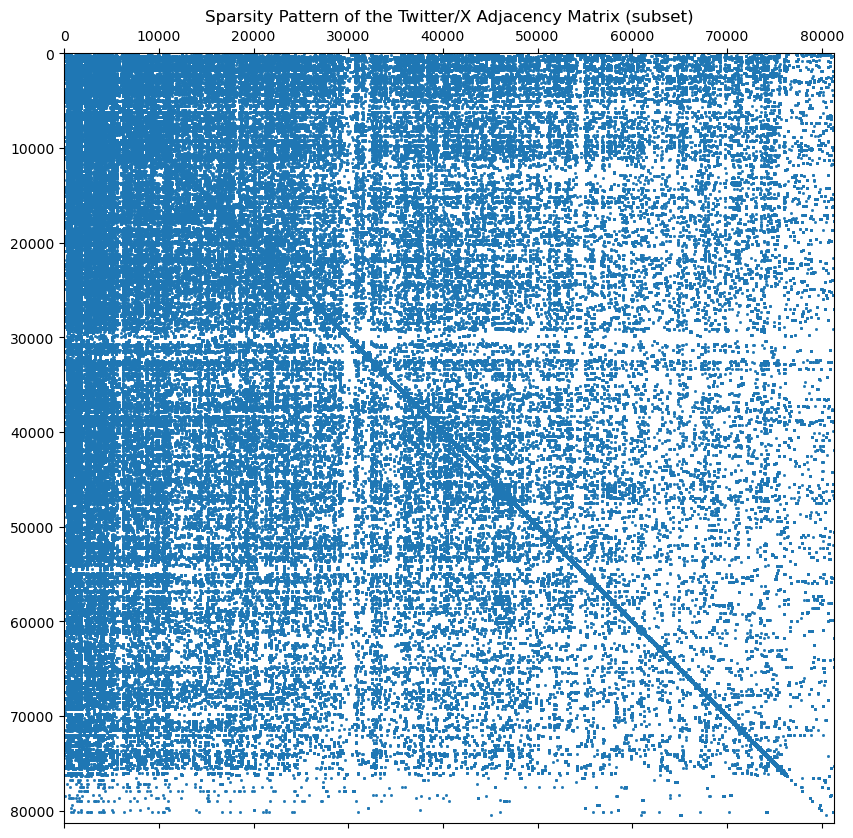

In [6]:
# Adjacency matrix as a sparse matrix (SciPy sparse)
adj_matrix = nx.adjacency_matrix(D)

plt.figure(figsize=(10, 10))
plt.spy(adj_matrix, markersize=1)
plt.title("Sparsity Pattern of the Twitter/X Adjacency Matrix (subset)")
plt.show()

### How sparse is this graph?

For a directed graph with $n$ nodes, the maximum possible number of directed
edges is $n^2$ (if self-loops are allowed).

Let:
- $n$ be the number of nodes,
- $m$ be the number of directed edges.

A simple measure of sparsity is the **edge density**
$
\frac{m}{n^2},
$
which represents the fraction of all possible directed edges that are actually present.
In large social networks, this quantity is typically very small.

In [7]:
n = D.number_of_nodes()
m = D.number_of_edges()

max_possible_edges = n * n  # includes possible self-loops
density = m / max_possible_edges

print(f"Number of nodes (n): {n:,}")
print(f"Number of edges (m): {m:,}")
print(f"Maximum possible directed edges (n^2): {max_possible_edges:,}")
print(f"Edge density (m / n^2): {density:.6g}  (~{100*density:.4f}% of possible edges)")

Number of nodes (n): 81,306
Number of edges (m): 1,768,149
Maximum possible directed edges (n^2): 6,610,665,636
Edge density (m / n^2): 0.000267469  (~0.0267% of possible edges)


Inspecting the neighbors of a specific node allows us to study local structure.

For a given node $u$, the **out-degree**
$$
d^{out}_u
$$
is the number of nodes it points to, i.e., the size of its adjacency list.
This quantity provides a simple measure of how many other users $u$ directly follows.

In [8]:
u = 7302682  # example user ID from the dataset

if u in D:
    neighbors_of_u = list(D.neighbors(u))  # out-neighbors for directed graphs
    print(f"Out-neighbors of {u}: {neighbors_of_u[:20]}{' ...' if len(neighbors_of_u) > 20 else ''}")
    print(f"Out-degree of {u}: {len(neighbors_of_u)}")
else:
    print(f"Node {u} is not present in the graph. Try a different node ID.")

Out-neighbors of 7302682: [22108185, 358346423, 18107941, 15108672, 17868918, 17503591, 17968886, 52144222, 31331740, 18323672, 103755670, 36663339, 31019764, 8437922, 100312878, 36767299, 16729508, 65974071, 49737738, 121484229] ...
Out-degree of 7302682: 22


### Saving the graph (GraphML)

To reuse this graph in future notebooks without rebuilding it from the text file, we can save it to disk.
We will use the **GraphML** format (`.graphml`), which is a widely supported, portable format for graphs.

After saving, you can reload the graph later with:

```python
D = nx.read_graphml("data/twitter_graph.graphml")

In [10]:
from pathlib import Path

out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)

graphml_path = out_dir / "twitter_graph.graphml"

nx.write_graphml(D, graphml_path)
print(f"Saved graph to: {graphml_path.resolve()}")

Saved graph to: /Users/victormpreciado/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/data/twitter_graph.graphml


### Sanity check: reloading the saved graph

Before moving on, we perform a quick **sanity check** by reloading the graph
from the saved GraphML file.

The goal is to verify that:
- the graph structure was saved correctly,
- the number of nodes and edges is preserved after reloading.

If the counts match those of the original graph $D$, then the save–reload
pipeline is working as expected and the graph can be safely reused in
future notebooks.

In [11]:
D2 = nx.read_graphml(graphml_path)
print("Reloaded graph:")
print("  nodes:", D2.number_of_nodes())
print("  edges:", D2.number_of_edges())

Reloaded graph:
  nodes: 81306
  edges: 1768149
